In [5]:
# Initialize Otter
!pip install otter-grader
import otter
grader = otter.Notebook("lab03.ipynb")

# Lab 3: Data Cleaning and Visualization

In this lab you will be working on visualizing a dataset from the City of Berkeley containing data on calls to the Berkeley Police Department. Information about the dataset can be found [at this link](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).

Note: This lab will not work on older versions of Python; make sure to work on DataHub.

**This assignment should be completed and submitted by 11:59 PM PDT on Tuesday, September 14th, 2021.**

**Content Warning: This lab includes an analysis of crime in Berkeley. If you feel uncomfortable about the topic, please feel free to contact your GSI or the instructors.**

## Setup

Note that we configure a custom default figure size. Virtually every default aspect of matplotlib [can be customized](https://matplotlib.org/users/customizing.html).

In [6]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 9)

## Part 1: Cleaning and Exploring the Data

To retrieve the dataset, we will use the `ds100_utils.fetch_and_cache` utility.

In [7]:
import requests
from pathlib import Path

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.
    
    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded 
    
    return: The pathlib.Path to the file.
    """
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir/Path(file)
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
    else:
        import time 
        created = time.ctime(file_path.stat().st_ctime)
        print("Using cached version downloaded at", created)
    return file_path

In [8]:
#import ds100_utils

data_dir = 'data'
data_url = 'http://www.ds100.org/fa20/resources/assets/datasets/lab04_data_fa20.zip'
file_name = 'lab04_data_fa20.zip'

# dest_path = ds100_utils.fetch_and_cache(data_url=data_url, file=file_name, data_dir=data_dir)
dest_path = fetch_and_cache(data_url=data_url, file=file_name, data_dir=data_dir)
print(f'Located at {dest_path}')

Downloading... Done!
Located at data/lab04_data_fa20.zip


We will now directly unzip the ZIP archive and start working with the uncompressed files.

Note: There is no single right answer regarding whether to work with compressed files in their compressed state or to uncompress them on disk permanently. If you for example need to work with multiple tools on the same files, or write many notebooks to analyze them, and they are not too large, it may be more convenient to uncompress them once.  But you may also have situations where you find it preferable to work with the compressed data directly.  

Python gives you tools for both approaches, and you should know how to perform both tasks in order to choose the one that best suits the problem at hand.

---

Run the cell below to extract the zip file into the data directory.

In [9]:
my_zip = zipfile.ZipFile(dest_path, 'r')
my_zip.extractall(data_dir)

Now, we'll use a method of the `Pathlib.Path` class called `glob` to list all files in the `data` directory. You will find useful information in pathlib [documentation](https://docs.python.org/3/library/pathlib.html).

Below, we use pathlib's `glob` method to store the list of all files' names from the `data_dir` directory in the variable `file_names`. These names should be strings that contain only the file name (e.g. `dummy.txt` not `data/dummy.txt`). The asterisk (*) character is used with the `glob` method to match any string.

In [10]:
from pathlib import Path
data_dir_path = Path('data') # creates a Path object that points to the data directory
file_names = [x.name for x in data_dir_path.glob('*') if x.is_file()]
file_names

['dummy.txt',
 'lab04_data_fa20.zip',
 'hello_world.py',
 'ben_kurtovic.py',
 'do_not_readme.md',
 'Berkeley_PD_-_Calls_for_Service.csv']

Let's now load the CSV file we have into a `pandas.DataFrame` object.

In [11]:
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,18022300,DISTURBANCE,04/18/2018 12:00:00 AM,22:17,DISORDERLY CONDUCT,3,09/06/2018 03:30:12 AM,"OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...",OREGON STREET & MCGEE AVE,Berkeley,CA
1,18026683,THEFT MISD. (UNDER $950),05/09/2018 12:00:00 AM,21:25,LARCENY,3,09/06/2018 03:30:13 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...",200 UNIVERSITY AVE,Berkeley,CA
2,18038550,THEFT MISD. (UNDER $950),05/18/2018 12:00:00 AM,20:00,LARCENY,5,09/06/2018 03:30:09 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA
3,18014810,BURGLARY AUTO,03/13/2018 12:00:00 AM,08:50,BURGLARY - VEHICLE,2,09/06/2018 03:30:08 AM,"1200 SIXTH ST\nBerkeley, CA\n(37.881142, -122....",1200 SIXTH ST,Berkeley,CA
4,18018643,ALCOHOL OFFENSE,03/31/2018 12:00:00 AM,13:29,LIQUOR LAW VIOLATION,6,09/06/2018 03:30:11 AM,"CENTER STREET &amp; SHATTUCK AVE\nBerkeley, CA...",CENTER STREET & SHATTUCK AVE,Berkeley,CA


We see that the fields include a case number, the offense type, the date and time of the offense, the "CVLEGEND" which appears to be related to the offense type, a "CVDOW" which has no apparent meaning, a date added to the database, and the location spread across four fields.

Let's also check some basic information about these files using the `DataFrame.info` and `DataFrame.describe` methods.

In [12]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3788 entries, 0 to 3787
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CASENO          3788 non-null   int64 
 1   OFFENSE         3788 non-null   object
 2   EVENTDT         3788 non-null   object
 3   EVENTTM         3788 non-null   object
 4   CVLEGEND        3788 non-null   object
 5   CVDOW           3788 non-null   int64 
 6   InDbDate        3788 non-null   object
 7   Block_Location  3788 non-null   object
 8   BLKADDR         3766 non-null   object
 9   City            3788 non-null   object
 10  State           3788 non-null   object
dtypes: int64(2), object(9)
memory usage: 325.7+ KB


Note that the `BLKADDR` column only has 3766 non-null entries, while the other columns all have 3788 entries. This is because the `.info()` method only counts non-null entries.

In [13]:
calls.describe()

,CASENO,CVDOW
count,3.788000e+03,3788.000000
mean,1.804387e+07,2.997888
std,2.665970e+04,1.952160
min,1.801375e+07,0.000000
25%,1.802444e+07,1.000000
50%,1.803530e+07,3.000000
75%,1.804537e+07,5.000000
max,1.809135e+07,6.000000


Notice that the functions above reveal type information for the columns, as well as some basic statistics about the numerical columns found in the DataFrame. However, we still need more information about what each column represents. Let's explore the data further in Question 1.

Before we go over the fields to see their meanings, the cell below will verify that all the events happened in Berkeley by grouping on the `City` and `State` columns. You should see that all of our data falls into one group.

In [14]:
calls.groupby(["City","State"]).count()

,,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR
City,State,,,,,,,,,
Berkeley,CA,3788,3788,3788,3788,3788,3788,3788,3788,3766


When we called `head()` on the Dataframe `calls`, it seemed like `OFFENSE` and `CVLEGEND` both contained information about the type of event reported. What is the difference in meaning between the two columns? One way to probe this is to look at the `value_counts` for each Series.

In [15]:
calls['OFFENSE'].value_counts().head(10)

BURGLARY AUTO               658
THEFT MISD. (UNDER $950)    633
DISTURBANCE                 277
VANDALISM                   248
VEHICLE STOLEN              235
THEFT FELONY (OVER $950)    214
BURGLARY RESIDENTIAL        194
ASSAULT/BATTERY MISD.       190
ROBBERY                     168
NARCOTICS                   118
Name: OFFENSE, dtype: int64

In [16]:
calls['CVLEGEND'].value_counts().head(10)

LARCENY                   871
BURGLARY - VEHICLE        658
DISORDERLY CONDUCT        279
ASSAULT                   263
VANDALISM                 248
MOTOR VEHICLE THEFT       235
FRAUD                     208
BURGLARY - RESIDENTIAL    194
ROBBERY                   168
DRUG VIOLATION            118
Name: CVLEGEND, dtype: int64

It seems like `OFFENSE` is more specific than `CVLEGEND`, e.g. "LARCENY" vs. "THEFT FELONY (OVER $950)". If you're unfamiliar with the term, "larceny" is a legal term for theft of personal property.

To get a sense of how many subcategories there are for each `OFFENSE`, we will set `calls_by_cvlegend_and_offense` equal to a multi-indexed series where the data is first indexed on the `CVLEGEND` and then on the `OFFENSE`, and the data is equal to the number of offenses in the database that match the respective `CVLEGEND` and `OFFENSE`. As you can see, `calls_by_cvlegend_and_offense["LARCENY", "THEFT FROM PERSON"]` returns 24 which means there are 24 instances of larceny with offense of type "THEFT FROM PERSON" in the database.

In [23]:
calls_by_cvlegend_and_offense = calls.groupby(["CVLEGEND", "OFFENSE"]).size()
calls_by_cvlegend_and_offense["LARCENY", "THEFT FROM PERSON"]
len(calls[calls["CVLEGEND"]=="LARCENY"]["OFFENSE"].unique()) # or .value_counts()

3

### Question 1

In the cell below, set `answer1` equal to a list of strings corresponding to the possible values for `OFFENSE` when `CVLEGEND` is "LARCENY". You can type the answer manually, or you can create an expression that automatically extracts the names.

<!--
BEGIN QUESTION
name: q1
-->

In [24]:
answer1 = len(calls[calls["CVLEGEND"]=="LARCENY"]["OFFENSE"].unique()) # or .value_counts()

In [25]:
grader.check("q1")

q1 results:
    q1 - 1 result:
        Trying:
            isinstance(answer1, list)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1 0
        Failed example:
            isinstance(answer1, list)
        Expected:
            True
        Got:
            False

        PYDEV DEBUGGER WARNING:
        sys.settrace() should not be used when the debugger is being used.
        This may cause the debugger to stop working correctly.
        If this is needed, please check: 
        http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
        to see how to restore the debug tracing back correctly.
        Call Location:
          File "/usr/lib/python3.7/doctest.py", line 1487, in run
            sys.settrace(save_trace)

    q1 - 2 result:
        Trying:
            all([isinstance(elt, str) for elt in answer1])
        Expecting:
            True
        **********************************************************************
        Line 1, in q1 1
        Failed example:
            all([isinstance(elt, str) for elt in answer1])
        Exception raised:
            Traceback (most recent call last):
              File "/usr/lib/python3.7/doctest.py", line 1337, in __run
                compileflags, 1), test.globs)
              File "<doctest q1 1[0]>", line 1, in <module>
                all([isinstance(elt, str) for elt in answer1])
            TypeError: 'int' object is not iterable

    q1 - 3 result:
        Trying:
            len(answer1) == 3
        Expecting:
            True
        **********************************************************************
        Line 1, in q1 2
        Failed example:
            len(answer1) == 3
        Exception raised:
            Traceback (most recent call last):
              File "/usr/lib/python3.7/doctest.py", line 1337, in __run
                compileflags, 1), test.globs)
              File "<doctest q1 2[0]>", line 1, in <module>
                len(answer1) == 3
            TypeError: object of type 'int' has no len()

    q1 - 4 result:
        Trying:
            all([elt in calls['OFFENSE'].values for elt in answer1])
        Expecting:
            True
        **********************************************************************
        Line 1, in q1 3
        Failed example:
            all([elt in calls['OFFENSE'].values for elt in answer1])
        Exception raised:
            Traceback (most recent call last):
              File "/usr/lib/python3.7/doctest.py", line 1337, in __run
                compileflags, 1), test.globs)
              File "<doctest q1 3[0]>", line 1, in <module>
                all([elt in calls['OFFENSE'].values for elt in answer1])
            TypeError: 'int' object is not iterable

    q1 - 5 result:
        Trying:
            set([a.strip().upper() for a in answer1]) == set(['THEFT FELONY (OVER $950)', 'THEFT FROM PERSON', 'THEFT MISD. (UNDER $950)'])
        Expecting:
            True
        **********************************************************************
        Line 1, in q1 4
        Failed example:
            set([a.strip().upper() for a in answer1]) == set(['THEFT FELONY (OVER $950)', 'THEFT FROM PERSON', 'THEFT MISD. (UNDER $950)'])
        Exception raised:
            Traceback (most recent call last):
              File "/usr/lib/python3.7/doctest.py", line 1337, in __run
                compileflags, 1), test.globs)
              File "<doctest q1 4[0]>", line 1, in <module>
                set([a.strip().upper() for a in answer1]) == set(['THEFT FELONY (OVER $950)', 'THEFT FROM PERSON', 'THEFT MISD. (UNDER $950)'])
            TypeError: 'int' object is not iterable

--- 

## Part 2: Visualization


## Pandas Examples

Pandas offers basic functionality for plotting. For example, the `DataFrame` and `Series` classes both have a `plot` method. 

As you learn to do data visualization, you may find the [pandas plotting documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)  helpful!

As an example of the built-in plotting functionality of pandas, the following example uses `plot` method of the `Series` class to generate a `barh` plot type to visually display the value counts for `CVLEGEND`.

There are also many other plots that we will explore throughout the lab.

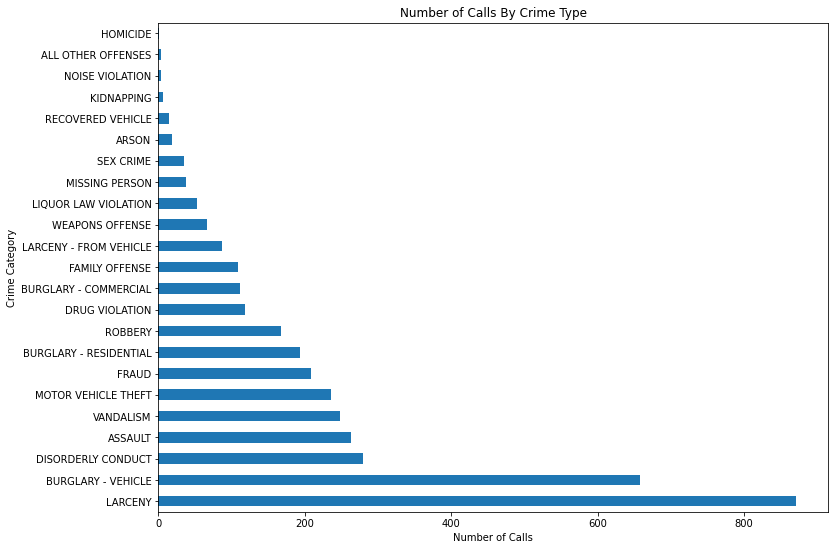

In [ ]:
ax = calls['CVLEGEND'].value_counts().plot(kind='barh')
ax.set_ylabel("Crime Category")
ax.set_xlabel("Number of Calls")
ax.set_title("Number of Calls By Crime Type");
ax2 = plt.gca()



## An Additional Note on Plotting in Jupyter Notebooks

You may have noticed that many of our code cells involving plotting end with a semicolon (;). This prevents any extra output from the last line of the cell that we may not want to see. Try adding this to your own code in the following questions!

### Question 2

Now it is your turn to make some plots using `pandas`.  Let's start by transforming the data so that it is easier to work with. We then will look at some distributions of the data. 

The CVDOW field isn't named helpfully and it is hard to see the meaning from the data alone. According to the website linked at the top of this notebook, CVDOW is actually indicating the day that events happened. 0->Sunday, 1->Monday ... 6->Saturday. 

#### Question 2a

Add a new column `Day` into the `calls` DataFrame that has the string weekday (eg. 'Sunday') for the corresponding value in CVDOW. For example, if the first 3 values of `CVDOW` are `[3, 6, 0]`, then the first 3 values of the `Day` column should be `["Wednesday", "Saturday", "Sunday"]`.

**Hint:** *Try using the [Series.map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) function on `calls["CVDOW"]`.  Can you assign this to the new column `calls["Day"]`?*

<!--
BEGIN QUESTION
name: q2a
-->

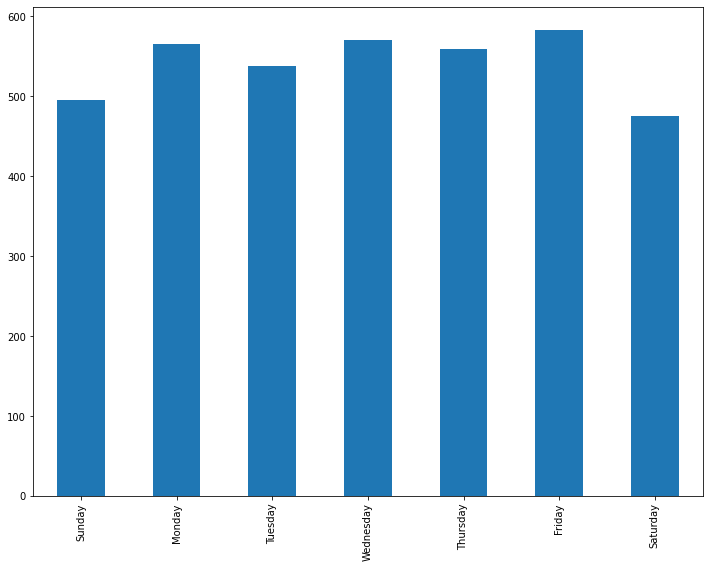

In [38]:
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
day_indices = range(7)
indices_to_days_dict = dict(zip(day_indices, days)) # Should look like {0:"Sunday", 1:"Monday", ..., 6:"Saturday"}
calls["Day"] = calls["CVDOW"].map(indices_to_days_dict)
calls[["CVDOW","Day"]]
#calls["Day"].value_counts()
ax = calls['Day'].value_counts().reindex(days).plot(kind='bar')

In [31]:
grader.check("q2a")

q2a results: All test cases passed!

#### Question 2b

Now let's look at the EVENTTM column which indicates the time for events. Since it contains hour and minute information, let's extract the hour info and create a new column named `Hour` in the `calls` DataFrame. You should save the hour as an `int`.


**Hint:** *Your code should only require one line*

<!--
BEGIN QUESTION
name: q2b
-->

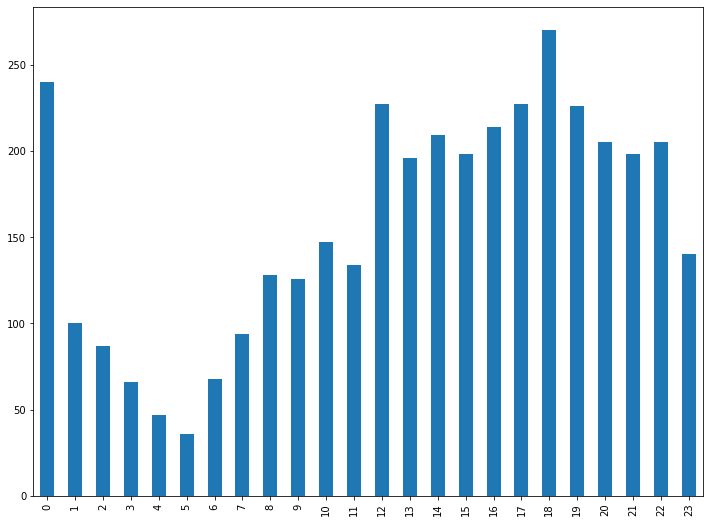

In [50]:
calls["Hour"] = calls["EVENTTM"].str[:2].astype(int)
calls["Hour"] 
ax = calls['Hour'].value_counts().reindex(range(24)).plot(kind='bar')

In [51]:
grader.check("q2b")

q2b results: All test cases passed!

#### Question 2c


Using `pandas`, construct a line plot with the count of the number of calls (entries in the table) for each hour of the day  **ordered by the time** (eg. `12:00 AM`, `1:00 AM`, ...). Please use the provided variable `hours` in your answer. Be sure that your axes are labeled and that your plot is titled. 

<!--
BEGIN QUESTION
name: q2c

-->

In [ ]:
hours = list(range(24))
...



# Leave this for grading purposes
ax_3d = plt.gca()

In [ ]:
grader.check("q2c")

##### Why do you think this happens? Are there more calls in the day or night? What are the most and least popular times? (Answer Below)

### Question 3

We can break down into some particular types of events to see their distribution. For example, let's make a bar plot for the CVLEGEND "ROBBERY". 

#### Question 3a

Use `pandas` to create a vertical bar plot of the number of total robberies reported on each day of the week, again ordered by the days of the week starting with Sunday. Please use the provided variable `filtered` in your answer. Be sure that your axes are labeled and that your plot is titled.

**Hint:** *This should be very similar to Question 2c*

<!--
BEGIN QUESTION
name: q3a
-->

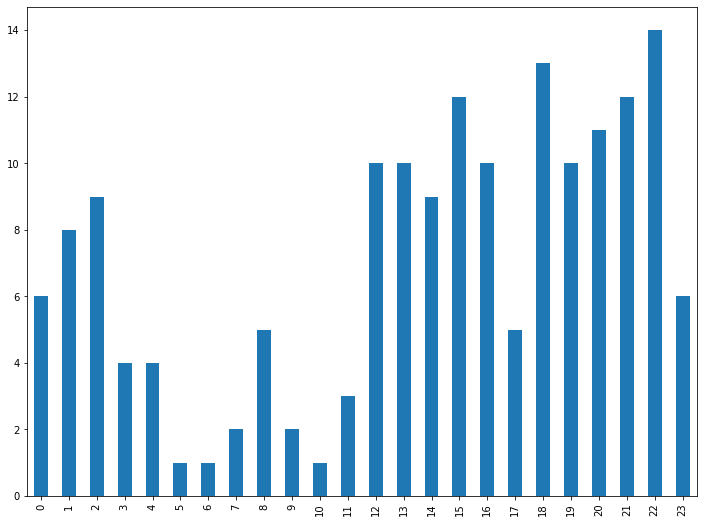

In [54]:
filtered = calls[calls["CVLEGEND"] == "ROBBERY"]
ax = filtered["Hour"].value_counts().reindex(range(24)).plot(kind='bar')



# Leave this for grading purposes
ax_4a = plt.gca()

In [55]:
grader.check("q3a")

q3a results:
    q3a - 1 result:
        Trying:
            import matplotlib 
        Expecting nothing
        ok
        Trying:
            np.alltrue(np.array([l.get_text() for l in ax_4a.xaxis.get_ticklabels()]) == days)
        Expecting:
            True
        **********************************************************************
        Line 2, in q3a 0
        Failed example:
            np.alltrue(np.array([l.get_text() for l in ax_4a.xaxis.get_ticklabels()]) == days)
        Exception raised:
            Traceback (most recent call last):
              File "/usr/lib/python3.7/doctest.py", line 1337, in __run
                compileflags, 1), test.globs)
              File "<doctest q3a 0[1]>", line 1, in <module>
                np.alltrue(np.array([l.get_text() for l in ax_4a.xaxis.get_ticklabels()]) == days)
            ValueError: shape mismatch: objects cannot be broadcast to a single shape

    q3a - 2 result:
        Trying:
            import matplotlib 
        Expecting nothing
        ok
        Trying:
            bars = [rect.get_height() for rect in ax_4a.get_children() 
                    if isinstance(rect, matplotlib.patches.Rectangle) and rect.get_x() != 0.0
                   ]
        Expecting nothing
        ok
        Trying:
            np.allclose(np.array(bars)[-7:], filtered['Day'].value_counts()[days].values)
        Expecting:
            True
        **********************************************************************
        Line 6, in q3a 1
        Failed example:
            np.allclose(np.array(bars)[-7:], filtered['Day'].value_counts()[days].values)
        Expected:
            True
        Got:
            False

    q3a - 3 result:
        Test case passed!

#### Question 3b

Do you observe anything interesting about the distribution of ROBBERY calls over a week? Which day is the peak for "ROBBERY"? Type a 1-2 sentence answer below.

### Question 4

In the cell below, generate a boxplot which examines the hour of day of each crime broken down by the `CVLEGEND` value.  To construct this plot use the [DataFrame.boxplot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html) documentation. You may want to rotate the `CVLEGEND` labels for better readability.

##### Looking at your plot, which crime type appears to have the largest interquartile range? Put your results into `answer4` as a string.


<!--
BEGIN QUESTION
name: q4
-->

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


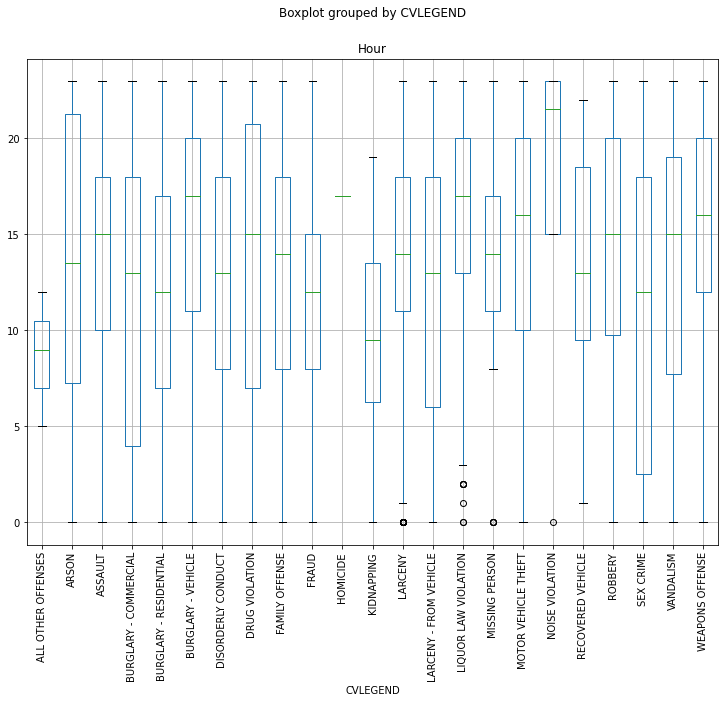

In [58]:
answer4 = ...
ax = calls.boxplot(column="Hour", by="CVLEGEND", rot=90)

In [ ]:
grader.check("q4")

**Important**: To make sure the test cases run correctly, click `Kernel>Restart & Run All` and make sure all of the test cases are still passing. Doing so will submit your code for you. 

If your test cases are no longer passing after restarting, it's likely because you're missing a variable, or the modifications that you'd previously made to your DataFrame are no longer taking place (perhaps because you deleted a cell). 

You may submit this assignment as many times as you'd like before the deadline.

**You must restart and run all cells before submitting. Otherwise, you may pass test cases locally, but not on our servers. We will not entertain regrade requests of the form, “my code passed all of my local test cases, but failed the autograder”.**

## Congratulations

Congrats! You are finished with this assignment.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)